<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/murrey_mml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/rongardF/tvdatafeed to /tmp/pip-req-build-z08lstw2
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed /tmp/pip-req-build-z08lstw2
  Resolved https://github.com/rongardF/tvdatafeed to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done


   Hisse Adı               Tarih   Son Fiyat  Giriş Seviyesi  Giriş Sinyali
0       AKSA 2024-06-21 06:00:00  126.400000       125.00000          False
1      ARCLK 2024-06-21 06:00:00  173.600010       175.00000          False
2      BANVT 2024-06-21 06:00:00  316.000000       312.50000          False
3      BASGZ 2024-06-21 06:00:00   31.900000        31.25000          False
4      BIOEN 2024-06-21 06:00:00   22.740000        21.87500          False
5      BRKSN 2024-06-21 06:00:00   36.619999        37.50000          False
6      CEMAS 2024-06-21 06:00:00    4.710000         4.68750          False
7       DESA 2024-06-21 06:00:00   31.340000        31.25000          False
8      KAREL 2024-06-21 06:00:00   15.760000        15.62500          False
9      KARSN 2024-06-21 06:00:00   14.410000        14.06250          False
10     LIDER 2024-06-21 06:00:00   76.500000        75.00000          False
11     LRSHO 2024-06-21 06:00:00    4.000000         3.90625          False
12     LUKSK

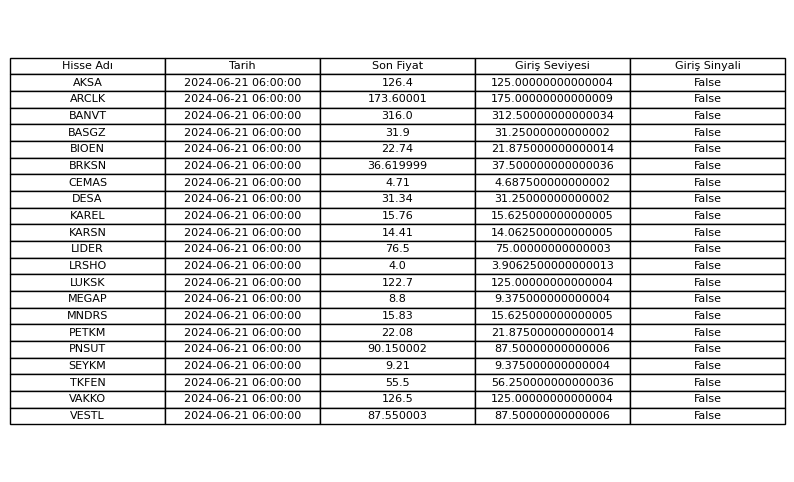

In [ ]:
!pip install git+https://github.com/rongardF/tvdatafeed tradingview-screener backtesting
import pandas as pd
import numpy as np
from tvDatafeed import TvDatafeed, Interval
from tradingview_screener import get_all_symbols
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# TradingView'den verileri çekmek için kimlik bilgileri
tv = TvDatafeed()

# Türk hisse senetlerini almak
Hisseler = get_all_symbols(market='turkey')
Hisseler = [symbol.replace('BIST:', '') for symbol in Hisseler]
Hisseler = sorted(Hisseler)

# Pivot seviyelerini hesaplamak için fonksiyon
def calculate_pivot_levels(data, frame=255, mult=1.0):
    logTen = np.log(10)
    log8 = np.log(8)
    log2 = np.log(2)
    lookback = round(frame * mult)

    data['high_lookback'] = data['high'].rolling(window=lookback).max()
    data['low_lookback'] = data['low'].rolling(window=lookback).min()

    vHigh = data['high_lookback']
    vLow = data['low_lookback']
    vDist = vHigh - vLow

    tmpHigh = np.where(vLow < 0, 0 - vLow, vHigh)
    tmpLow = np.where(vLow < 0, 0 - vLow - vDist, vLow)

    sfVar = np.log(0.4 * tmpHigh) / logTen - np.floor(np.log(0.4 * tmpHigh) / logTen)
    SR = np.where(tmpHigh > 25,
                  np.where(sfVar > 0,
                           np.exp(logTen * (np.floor(np.log(0.4 * tmpHigh) / logTen) + 1)),
                           np.exp(logTen * np.floor(np.log(0.4 * tmpHigh) / logTen))),
                  100 * np.exp(log8 * np.floor(np.log(0.005 * tmpHigh) / log8)))

    nVar1 = np.log(SR / (tmpHigh - tmpLow)) / log8
    nVar2 = nVar1 - np.floor(nVar1)
    N = np.where(nVar1 <= 0, 0, np.where(nVar2 == 0, np.floor(nVar1), np.floor(nVar1) + 1))

    SI = SR * np.exp(-N * log8)
    M = np.floor(1.0 / log2 * np.log((tmpHigh - tmpLow) / SI) + 0.0000001)
    I = np.round((tmpHigh + tmpLow) * 0.5 / (SI * np.exp((M - 1) * log2)))

    Bot = (I - 1) * SI * np.exp((M - 1) * log2)
    Top = (I + 1) * SI * np.exp((M - 1) * log2)

    doShift = (tmpHigh - Top > 0.25 * (Top - Bot)) | (Bot - tmpLow > 0.25 * (Top - Bot))
    ER = np.where(doShift, 1, 0)

    MM = np.where(ER == 0, M, np.where(np.logical_and(ER == 1, M < 2), M + 1, 0))
    NN = np.where(ER == 0, N, np.where(np.logical_and(ER == 1, M < 2), N, N - 1))

    finalSI = np.where(ER == 1, SR * np.exp(-NN * log8), SI)
    finalI = np.where(ER == 1, np.round((tmpHigh + tmpLow) * 0.5 / (finalSI * np.exp((MM - 1) * log2))), I)
    finalBot = np.where(ER == 1, (finalI - 1) * finalSI * np.exp((MM - 1) * log2), Bot)
    finalTop = np.where(ER == 1, (finalI + 1) * finalSI * np.exp((MM - 1) * log2), Top)

    Increment = (finalTop - finalBot) / 8
    absTop = np.where(vLow < 0, -(finalBot - 3 * Increment), finalTop + 3 * Increment)

    pivot_levels = {
        'Plus38': absTop,              # +3/8 Tersine dönüş
        'Plus28': absTop - Increment,  # +2/8 İleri Aşırı Alım
        'Plus18': absTop - 2 * Increment,  # +1/8 Aşırı Alım
        'EightEight': absTop - 3 * Increment,  # 8/8 Güçlü Direnç
        'SevenEight': absTop - 4 * Increment,  # 7/8 Zayıf Destek/Direnç
        'SixEight': absTop - 5 * Increment,  # 6/8 Güçlü Pivot Geri Dönüş
        'FiveEight': absTop - 6 * Increment,  # 5/8 Trade Aralığı Tepe Seviyesi
        'FourEight': absTop - 7 * Increment,  # 4/8 Ana Destek/Direnç
        'ThreeEight': absTop - 8 * Increment,  # 3/8 Trade Aralığı Dip
        'TwoEight': absTop - 9 * Increment,  # 2/8 Güçlü Pivot Geri Dönüş
        'OneEight': absTop - 10 * Increment,  # 1/8 Zayıf Destek/Direnç
        'ZeroEight': absTop - 11 * Increment,  # 0/8 Güçlü Destek
        'Minus18': absTop - 12 * Increment,  # -1/8 Aşırı Satım
        'Minus28': absTop - 13 * Increment,  # -2/8 İleri Aşırı Satım
        'Minus38': absTop - 14 * Increment  # -3/8 İleri Aşırı Satım

    }

    return pivot_levels

# Hisse senetleri için sinyalleri raporlamak
def get_signals(symbols, exchange, interval, n_bars):
    reports = []

    for symbol in symbols:
        try:
            data = tv.get_hist(symbol, exchange, interval=interval, n_bars=n_bars)
            data.reset_index(inplace=True)

            pivot_levels = calculate_pivot_levels(data)
            for key, value in pivot_levels.items():
                data[key] = value

            # Alım sinyali belirleme
            data['Buy_Signal'] = np.where(
                (data['low'] <= data['SixEight']) &  # SixEight seviyesini test ediyor veya etmiş
                (data['high'] >= data['SixEight']) &  # SixEight seviyesini geçiyor veya eşit
                (data['close'] < data['SevenEight']),  # Mevcut fiyat SevenEight seviyesinin altında
                True, False
            )

            # Alım sinyali ve giriş seviyesi kontrolü
            for i in range(1, len(data)):
                if data.loc[i, 'Buy_Signal']:
                    entry_level = data.loc[i, 'SixEight']
                    # Bir sonraki çubukta sinyal geçerli mi kontrol et
                    if i + 1 < len(data) and data.loc[i + 1, 'Buy_Signal']:
                        reports.append([symbol, data.loc[i, 'datetime'], data.loc[i, 'close'], entry_level, True])
                    else:
                        reports.append([symbol, data.loc[i, 'datetime'], data.loc[i, 'close'], entry_level, False])

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")

    return pd.DataFrame(reports, columns=['Hisse Adı', 'Tarih', 'Son Fiyat', 'Giriş Seviyesi', 'Giriş Sinyali'])

# Verileri çekmek ve raporlamak
interval = Interval.in_daily
n_bars = 255
exchange = 'BIST'

signal_report = get_signals(Hisseler, exchange, interval, n_bars)
print(signal_report)

# Tablo olarak gösterme
print(tabulate(signal_report, headers='keys', tablefmt='grid'))

# Görselleştirme
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=signal_report.values, colLabels=signal_report.columns, cellLoc='center', loc='center')
plt.show()
